<a href="https://colab.research.google.com/github/worklifesg/Python-for-Computer-Vision-with-OpenCV-and-Deep-Learning/blob/main/5.%20Object%20Detection%20with%20OpenCV%20and%20Python/7_ObjectDetection_OpenCV_WaterShedAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Object Detection with OpenCV and Python

In this section, we will cover the <b> WaterShed Algorithm:</b>

- In geography, <b> watershed </b> is a land area that channels rainfalls and snowmelt to creeks, streams and rivers and eventually to outflow points such as reservoirs, bays, and ocean. These can be <b> segmented as topograhical maps with boundaries. </b>
- In case of image, this algorithm transformation <b> treats the image it operates like a topographic map with brightness of each point representing its height, and finds the lines tthat run along the tops of ridges </b>
- <b> Gray scale image: </b>
 - High intensity - peaks and hills
 - Low intensity - valleys
- This algorithm can then fill every isolated valleys <b>(local minima)</b> with different colored water <b> (labels) </b> 
- In general, as water rises, <b>depending upon peaks (gradients)</b>, water from different valleys <b> (different segments of image)</b> with differnt colors could start to merge. The algorithm creates barriers <b> (segment edge boundaries)</b> in locations where water merges, i.e. create boundaries where brightness of different segments tends to merge.
- <b> Useful for segmenting images into background and foreground </b>
- Also we can <b> manually set seeds </b>, that allow us to manually start where the valleys of the watersheds go.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display(img,cmap='gray'):
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)
  ax.imshow(img,cmap='gray')

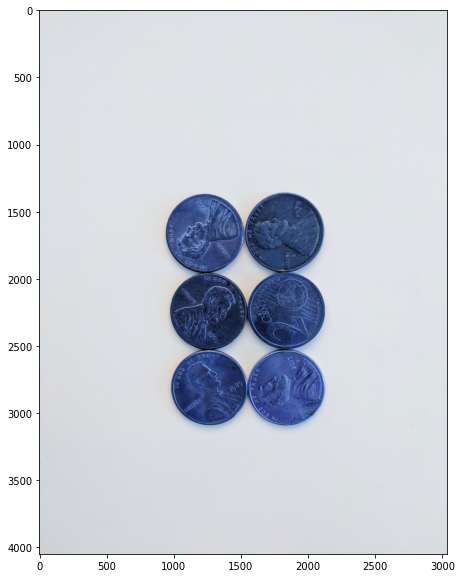

In [2]:
sep_coins = cv2.imread('pennies.jpg')
display(sep_coins)

For human it is very easy to differentiate the coins but machine with most of the algorithms see this as large chunck with white background

Let us check the previous algorithms how segmentation works

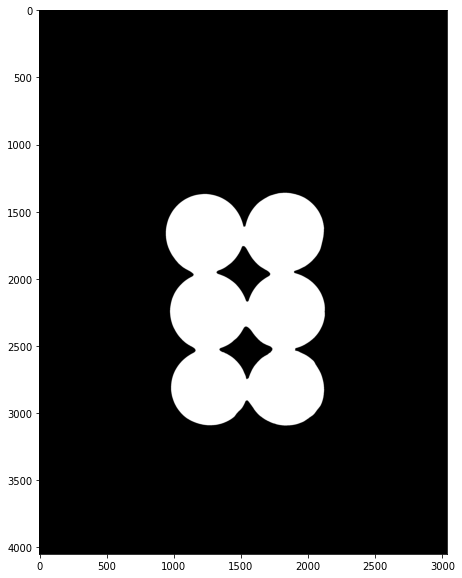

In [3]:
# MEDIAN BLUR
# Grayscale
# Binary Threshold
# Find Contours

sep_blur = cv2.medianBlur(sep_coins,25)
gray_sep_coins = cv2.cvtColor(sep_blur,cv2.COLOR_BGR2GRAY)
ret, th1 = cv2.threshold(gray_sep_coins,160,255,cv2.THRESH_BINARY_INV)
display(th1)

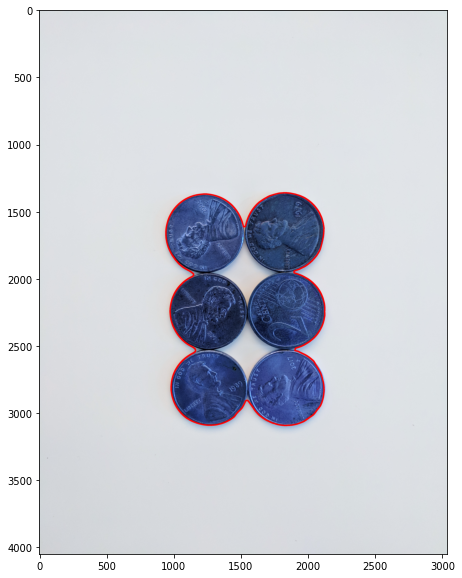

In [4]:
contours,hierarchy = cv2.findContours(th1.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
  if hierarchy[0][i][3] == -1:
    cv2.drawContours(sep_coins,contours,i,(255,0,0),10)
display(sep_coins)

As we can see with other algorithms, the segmention is one large big segment which is not what we expect from each coin segementation


---

#### Watershed Algorithm

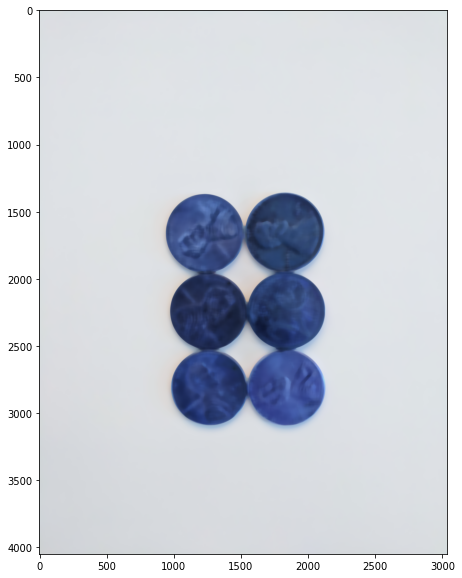

In [5]:
img = cv2.imread('pennies.jpg')
img = cv2.medianBlur(img, 35) #quite a blur
display(img)

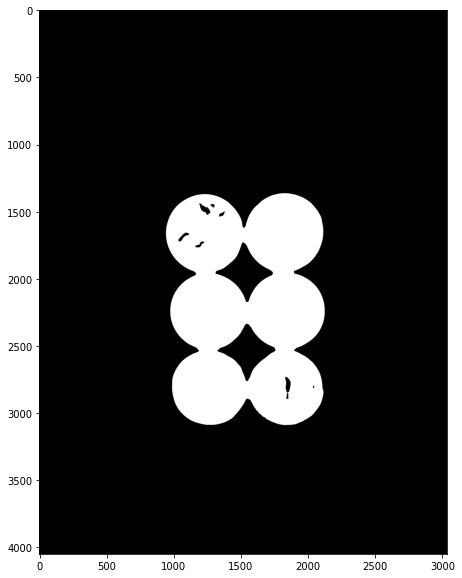

In [6]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
display(thresh)

Even without high blur, the markings on coin are detected which can be removed using Otsu's method

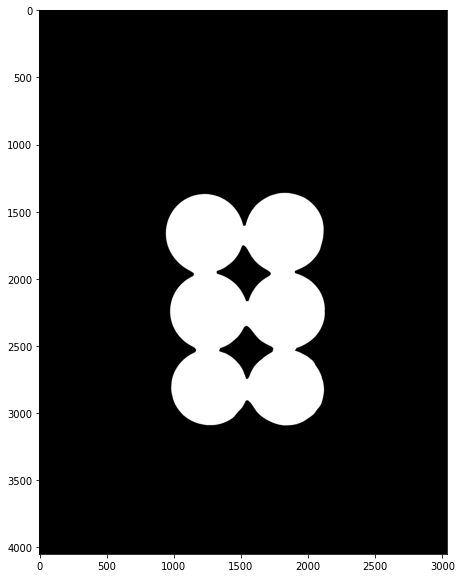

In [7]:
img = cv2.imread('pennies.jpg')
img = cv2.medianBlur(img, 35) #quite a blur
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
display(thresh)

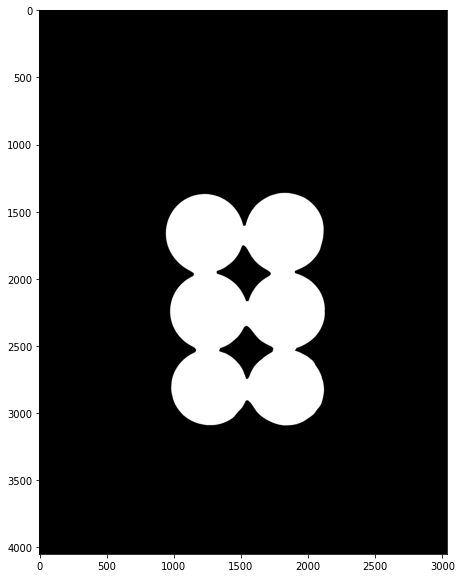

In [8]:
# Noise removal (basically for complex images)

kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)
display(opening)

We still have issue as all coins are still connected and are not segmented.

- we can use DISTANCE transformation - iamge becomes brighter at the center and fases are going away

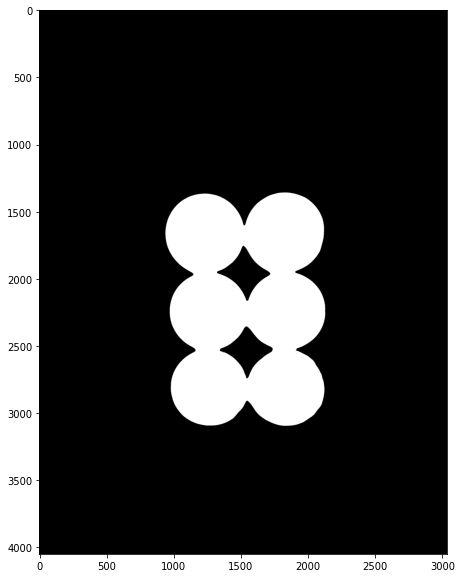

In [9]:
sure_bg = cv2.dilate(opening,kernel,iterations=3)
display(sure_bg)

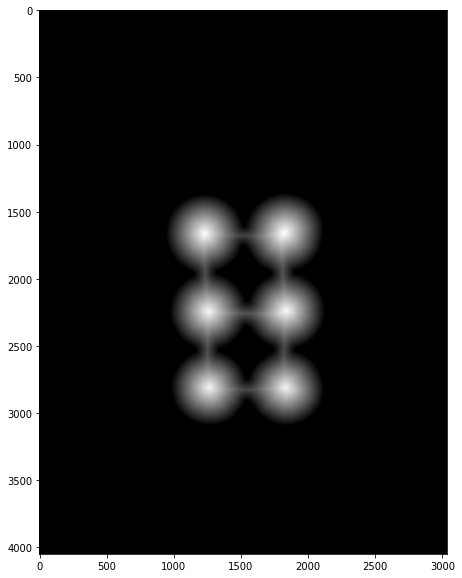

In [10]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,maskSize=5)
display(dist_transform)

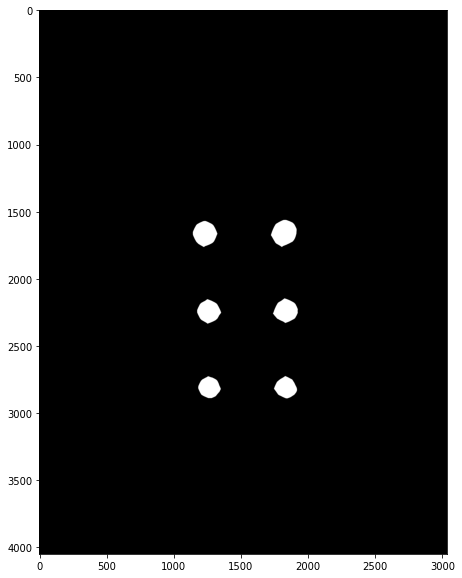

In [11]:
ret,sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

display(sure_fg)

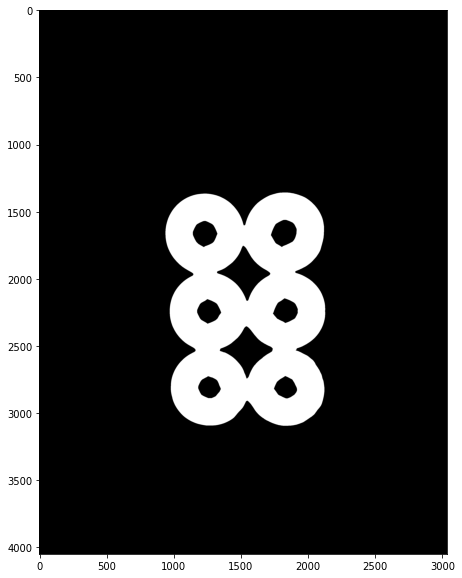

In [12]:
#watershed for unknown regions
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg,sure_fg)
display(unknown)

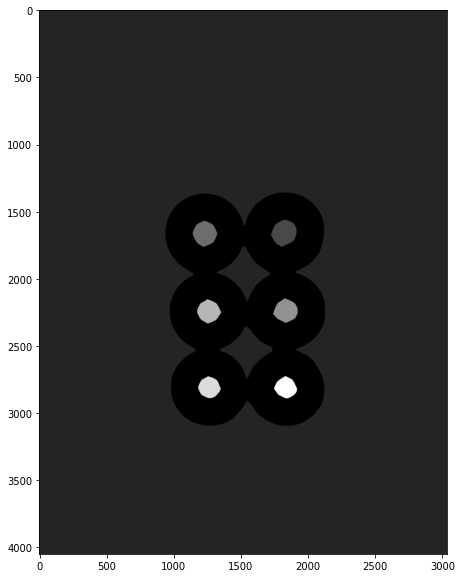

In [13]:
# 3 steps to make markers

ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1 #as markers are zero

markers[unknown==255] = 0 #removing unknwon black parts

display(markers) #background is gray so we know the size of coin as well

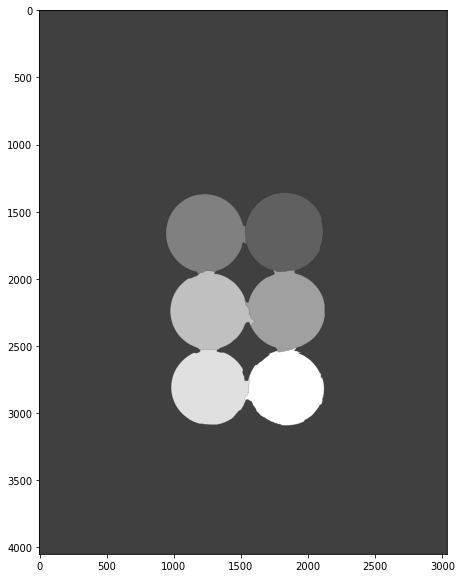

In [14]:
markers =cv2.watershed(img,markers)
display(markers) #six distinct markers

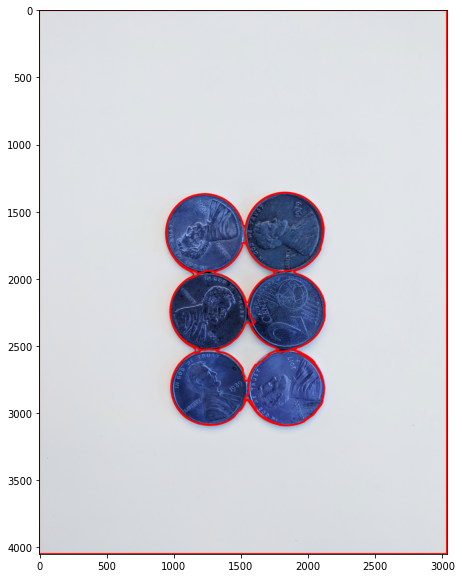

In [15]:
contours,hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
  if hierarchy[0][i][3] == -1:
    cv2.drawContours(sep_coins,contours,i,(255,0,0),10)
display(sep_coins)